### Optimizing Insurance Prediction in TensorFlow: Hyperparameter Tuning with Optuna

### Step 0: Imports and Reading Data

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm

!pip install optuna
!pip install optuna-integration
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")


### Step 1: Data Understanding
- Dataframe `shape`
- `head` and `tail`
- `dtypes`
- `describe`

In [3]:
df.shape

(1338, 7)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Step 2: Data Preparation
where applicable:
- Dropping irrelevant columns and rows
- Check for `nan`
- Identifying duplicated columns and rows
- Renaming columns
- Feature creation

In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
df.duplicated().sum()

1

In [10]:
# Find the duplicated row
df.loc[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [11]:
# Drop the duplicated row
df = df[~df.duplicated()].copy()
df.duplicated().sum()

0

### Step 3: Feature Understanding
(Univariate analysyis)
- Plotting Feature Distributions
  - Histogram
  - KDE
  - Boxplot

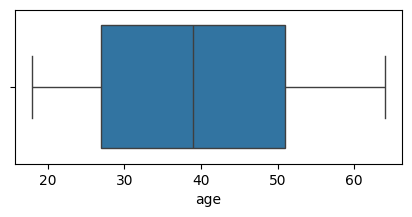

In [12]:
plt.figure(figsize=(5,2))
sns.boxplot(x=df['age']);

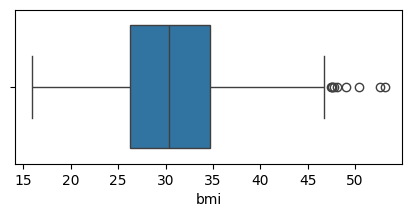

In [13]:
plt.figure(figsize=(5,2))
sns.boxplot(x=df['bmi']);

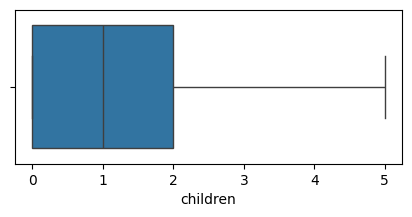

In [14]:
plt.figure(figsize=(5,2))
sns.boxplot(x=df['children']);

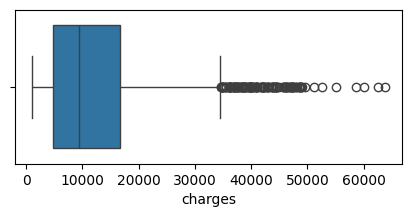

In [15]:
plt.figure(figsize=(5,2))
sns.boxplot(x=df['charges']);

Note: The outliers oberved with the boxplots might not realy be outliers. For example: there exist people with bmi of 50.
This is where domain knwowledge is crucial

<Axes: >

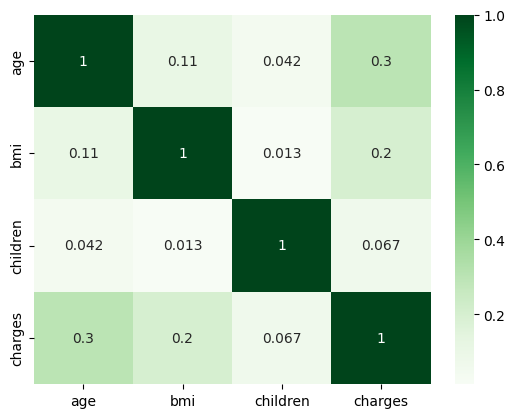

In [16]:
df_corr = df[['age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(df_corr, annot=True, cmap='Greens')

Transforming data for the model
- OneHotEnconding categorical/binary features
- Train-test split
- Normalization

In [17]:
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), ["sex", "smoker", "region"])
)

X = df.drop("charges", axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct.fit(X_train)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal = tf.convert_to_tensor(X_train_normal, dtype=tf.float32)
X_test_normal = tf.convert_to_tensor(X_test_normal, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [18]:
tf.reduce_mean(y_train) # this mean will be used as the bias_initializer for the output layer (Idea from karpathy.github.io)

<tf.Tensor: shape=(), dtype=float32, numpy=13030.203>

### Step 4: Model development
Optuna is used for hyperparmeters search

In [19]:
# Model creation function

# random seed for reproducibility
tf.keras.utils.set_random_seed(42)

def create_model(hyperparameters):
    model = tf.keras.Sequential()
    n_layers = hyperparameters['n_layers']
    for i in range(n_layers):
        n_units = hyperparameters[f'n_units_l_{i+1}']
        activation = hyperparameters[f'act_fn_l_{i+1}']
        model.add(tf.keras.layers.Dense(units=n_units, activation=activation))
        if i == n_layers - 1 and hyperparameters['dropout_rate'] > 0:
            model.add(tf.keras.layers.Dropout(rate=hyperparameters['dropout_rate']))
    model.add(tf.keras.layers.Dense(units=hyperparameters['last_l_units'], activation=hyperparameters['last_l_activation']))
    model.add(tf.keras.layers.Dense(1, bias_initializer=tf.keras.initializers.Constant(13030.203)))
    optimizer = getattr(tf.optimizers, hyperparameters['optimizer'])(learning_rate=hyperparameters[f"{hyperparameters['optimizer']}_learning_rate"])
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
    return model

# Optuna objective function
def objective(trial):
    hyperparameters = {
        'n_layers': trial.suggest_int('n_layers', 1, 4),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'last_l_units': trial.suggest_int('last_l_units', 1, 128),
        'last_l_activation': trial.suggest_categorical('last_l_activation', ['relu', 'tanh', 'swish']),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'Adam_learning_rate': trial.suggest_float('Adam_learning_rate', 1e-4, 1e-2),
        'RMSprop_learning_rate': trial.suggest_float('RMSprop_learning_rate', 1e-4, 1e-2),
    }
    for i in range(hyperparameters['n_layers']):
        hyperparameters[f'n_units_l_{i+1}'] = trial.suggest_int(f'n_units_l_{i+1}', 4, 128)
        hyperparameters[f'act_fn_l_{i+1}'] = trial.suggest_categorical(f'act_fn_l_{i+1}', ['relu', 'tanh', 'swish'])

    model = create_model(hyperparameters)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Early stoping
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose=0, mode='min', restore_best_weights=True, start_from_epoch=10)

    model.fit(X_train_normal, y_train,
              validation_split=0.1,
              batch_size=batch_size,
              epochs=500,
              verbose=0,
              callbacks = [stop, TFKerasPruningCallback(trial, "val_mae")])
    loss, mae = model.evaluate(X_test_normal, y_test, verbose=0)
    return round(mae, 3)

# Optuna study

n_trials = 300  # Adjust n_trials as needed
progress_bar = tqdm(total=n_trials, desc='Optimization Progress')

# Callback function to update the progress bar
def tqdm_callback(study, trial):
    progress_bar.update(1)

# Optuna study
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10),
                            sampler=optuna.samplers.TPESampler(seed=42))

# Start optimization with the progress bar update callback
study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback], show_progress_bar=False)

# Close the progress bar after optimization
progress_bar.close()

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])



Optimization Progress: 100%|██████████| 300/300 [35:20<00:00,  7.07s/it]


In [20]:
best_hyperparameters = study.best_trial.params
best_hyperparameters

{'n_layers': 4,
 'dropout_rate': 0.01922402746814028,
 'last_l_units': 73,
 'last_l_activation': 'swish',
 'optimizer': 'Adam',
 'Adam_learning_rate': 0.006023509472340285,
 'RMSprop_learning_rate': 0.009529425525399074,
 'n_units_l_1': 54,
 'act_fn_l_1': 'tanh',
 'n_units_l_2': 87,
 'act_fn_l_2': 'tanh',
 'n_units_l_3': 13,
 'act_fn_l_3': 'swish',
 'n_units_l_4': 98,
 'act_fn_l_4': 'swish',
 'batch_size': 16}

In [21]:
tf.keras.utils.set_random_seed(42)
# Retrain with best hyperparameters
best_hyperparameters = study.best_trial.params
model = create_model(best_hyperparameters)
# Early stoping
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose=0, mode='min', restore_best_weights=True, start_from_epoch=10)

history = model.fit(X_train_normal, y_train, validation_split=0.1, batch_size=best_hyperparameters['batch_size'], epochs=500, verbose=1, callbacks=[stop])
loss, mae = model.evaluate(X_test_normal, y_test, verbose=0)
print(f"Retrained model MAE: {mae}")

Epoch 1/500
61/61 [==============================] - 2s 8ms/step - loss: 7425.2666 - mae: 7425.2666 - val_loss: 4845.9170 - val_mae: 4845.9170
Epoch 2/500
61/61 [==============================] - 0s 3ms/step - loss: 4467.8286 - mae: 4467.8286 - val_loss: 3905.0957 - val_mae: 3905.0957
Epoch 3/500
61/61 [==============================] - 0s 3ms/step - loss: 3168.3706 - mae: 3168.3706 - val_loss: 2984.1289 - val_mae: 2984.1289
Epoch 4/500
61/61 [==============================] - 0s 3ms/step - loss: 2901.7107 - mae: 2901.7107 - val_loss: 2099.3220 - val_mae: 2099.3220
Epoch 5/500
61/61 [==============================] - 0s 3ms/step - loss: 2599.9287 - mae: 2599.9287 - val_loss: 2012.8674 - val_mae: 2012.8674
Epoch 6/500
61/61 [==============================] - 0s 3ms/step - loss: 2542.2908 - mae: 2542.2908 - val_loss: 1927.5933 - val_mae: 1927.5933
Epoch 7/500
61/61 [==============================] - 0s 3ms/step - loss: 2429.4507 - mae: 2429.4507 - val_loss: 1918.3721 - val_mae: 1918.3721

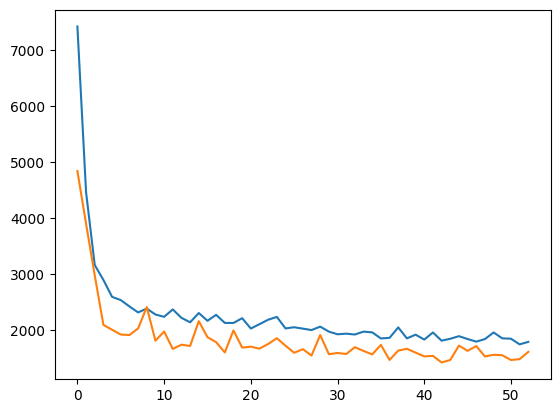

In [22]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.show()

In [23]:
# The model can be saved for later use
model.save("insurance_model")

==== End of notebook ====